In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layer_dims, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layer_dims = layer_dims
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    ########################################################################################################################
    
    def __initialize_parameters(self):
        layer_dims = self.layer_dims
        parameters = {}
        np.random.seed(1)
        for i in range(1,len(layer_dims)):
            parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
            parameters['b' + str(i)] = np.zeros((layer_dims[i], 1))
        self.parameters = parameters

        
        
    # Forvard part
    def __forward_linear_activation(self, A_prev, W, b):
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
        A = self.__sigmoid(Z)
        activation_cache = Z
        cache = (linear_cache, activation_cache)
        return A, cache
    
    def __multilayer_forward(self, X):       
        parameters = self.parameters
        caches = []
        L = len(parameters)//2
        for i in range(1, L):
            A_prev = X 
            A, cache = self.__forward_linear_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)])
            caches.append(cache)
        AL, cache = self.__forward_linear_activation(A, parameters["W"+str(L)], parameters["b"+str(L)])
        caches.append(cache)
        assert(AL.shape == (1,X.shape[1]))
        return AL, caches

    
    
    # Backward part
    def __backward_linear_activation(self, dA, cache):
        linear_cache, activation_cache = cache
        Z = activation_cache
        s = 1/(1 + np.exp(-Z))
        dZ = dA * s * (1-s)
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = 1 / m * np.dot(dZ, A_prev.T)
        db = 1 / m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db

    def __multilayer_backward(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__backward_linear_activation(dAL, current_cache)
        for i in reversed(range(L-1)):
            current_cache = caches[i]
            dA_prev_temp, dW_temp, db_temp = self.__backward_linear_activation(grads["dA" + str(i + 1)], current_cache)
            grads["dA" + str(i)] = dA_prev_temp
            grads["dW" + str(i + 1)] = dW_temp
            grads["db" + str(i + 1)] = db_temp
        return grads
    
    
    
    def __update_parameters(self, grads):
        parameters = self.parameters;
        learning_rate = self.learning_rate
        L = len(parameters) // 2
        for i in range(L):
            parameters["W" + str(i + 1)] = parameters["W" + str(i + 1)] - learning_rate * grads["dW" + str(i + 1)]
            parameters["b" + str(i + 1)] = parameters["b" + str(i + 1)] - learning_rate * grads["db" + str(i + 1)]
        self.parameters = parameters;
        
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J

    def fit(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        costs = []
        self.__initialize_parameters()
        
        for i in range(0, self.num_iter):
            AL, caches = self.__multilayer_forward(X)
            cost = self.compute_cost(AL, Y)
            grads = self.__multilayer_backward(AL, Y, caches)
            self.__update_parameters(grads)
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)

        if print_cost:
                plt.plot(costs)
                plt.ylabel("Cost")
                plt.xlabel("Iteration, *1000")
                plt.show()

    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)  
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        probs = self.__multilayer_forward(X)[0]
        return np.column_stack((probs.T, 1 - probs.T))
    
    

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


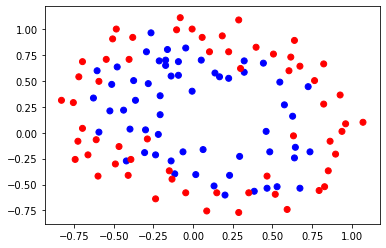

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 10000)
#cls = NeuralNet(layer_dims = [2,2,1] , learning_rate = 0.5, num_iter = 4000)
#cls = NeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 1, num_iter = 14000)

Cost after iteration 0: 0.693375
Cost after iteration 100: 0.692494
Cost after iteration 200: 0.690371
Cost after iteration 300: 0.690174
Cost after iteration 400: 0.690076
Cost after iteration 500: 0.689891
Cost after iteration 600: 0.689336
Cost after iteration 700: 0.686717
Cost after iteration 800: 0.676092
Cost after iteration 900: 0.645763
Cost after iteration 1000: 0.604054
Cost after iteration 1100: 0.583968
Cost after iteration 1200: 0.543418
Cost after iteration 1300: 0.480817
Cost after iteration 1400: 0.435991
Cost after iteration 1500: 0.408654
Cost after iteration 1600: 0.390582
Cost after iteration 1700: 0.376805
Cost after iteration 1800: 0.364515
Cost after iteration 1900: 0.352246
Cost after iteration 2000: 0.342077
Cost after iteration 2100: 0.334722
Cost after iteration 2200: 0.328427
Cost after iteration 2300: 0.323034
Cost after iteration 2400: 0.318466
Cost after iteration 2500: 0.314234
Cost after iteration 2600: 0.310039
Cost after iteration 2700: 0.306148
Cost

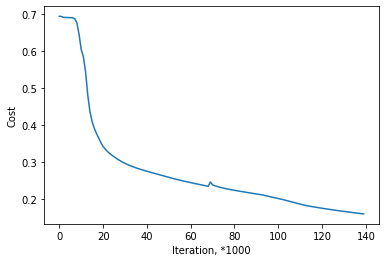

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W1': array([[  2.83796529,  -0.88145548],
       [ -4.08436797,   3.45942622],
       [  1.51714407, -14.47341644],
       [  0.96409361,   0.43809938],
       [  1.65184664,  -0.75026545],
       [  6.55927739,   6.08291953],
       [  1.54624562,   0.318103  ],
       [  3.17996632,   0.91512039],
       [  0.99819611,   0.25070614],
       [ -1.59770007,  -9.62057375],
       [  0.54956004,   3.0056181 ],
       [ -5.34645728,  -1.44231045],
       [  3.22564886,  -5.75573641],
       [ -3.33226494,  -0.31659732],
       [  2.23062353,   0.52547801],
       [  9.25158525,   1.45128973],
       [  1.16683501,   0.24759074],
       [  1.24785507,   0.25594812],
       [ -0.3019523 ,   1.91223805],
       [ -0.31847688,   1.04291053]]), 'b1': array([[ 7.64021296e+00],
       [-2.13238342e+00],
       [-7.54137458e+00],
       [-3.25901452e-01],
       [ 5.54622318e-03],
       [-1.18410750e+01],
       [-3.68557814e+00],
       [ 1.93285604e+00],
       [-1.71695467e+00],
       [ 1.

In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.99971087e-01, 2.89131849e-05],
       [9.49143781e-01, 5.08562191e-02],
       [9.99964616e-01, 3.53840877e-05],
       [9.97600444e-01, 2.39955599e-03],
       [9.73008015e-01, 2.69919847e-02],
       [9.92185224e-01, 7.81477596e-03],
       [9.98595147e-01, 1.40485257e-03],
       [7.98878500e-01, 2.01121500e-01],
       [9.76942452e-01, 2.30575477e-02],
       [8.71709353e-01, 1.28290647e-01],
       [5.16100657e-01, 4.83899343e-01],
       [6.32962335e-01, 3.67037665e-01],
       [9.77147304e-01, 2.28526961e-02],
       [3.02873233e-01, 6.97126767e-01],
       [9.97561460e-01, 2.43854025e-03],
       [9.54917808e-01, 4.50821921e-02],
       [9.99998886e-01, 1.11358703e-06],
       [9.58719550e-01, 4.12804504e-02],
       [9.99969679e-01, 3.03205574e-05],
       [8.76465090e-01, 1.23534910e-01],
       [5.64978085e-01, 4.35021915e-01],
       [6.38071201e-01, 3.61928799e-01],
       [9.00845135e-01, 9.91548654e-02],
       [3.16991103e-01, 6.83008897e-01],
       [6.670068

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1])

In [13]:
accuracy_score(Y, Y_hat)

0.923728813559322

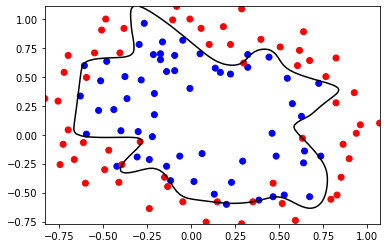

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

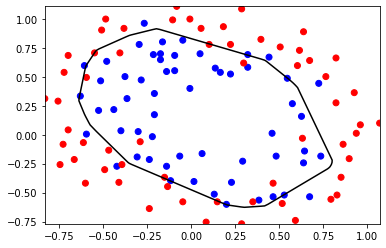

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576